# Programming Assignment - 3

# Optimizers

---


The aim of this section is to understand the loss surface of the neural network and study the behaviour of various optimization algorithms on it.

---

## To do

**1. Implement Gradient Descent based Optimizers**

Study and Implement the following Optimizers on a two dimensional convex fuction of the form $f(w_1,w_2)=a_1(w_1-b_1)^2 +a_2(w_2-b_2)^2+c$ where $a_1,a_2,b_1,b_2$ and $c$ are hyperparameters which affect the rate of convergence of these algorithms.

* Mini batch Gradient descent **(2 points)**
* SGD with Momentum **(2 points)**
* Nesterov's Accelerated Gradient **(2 points)**
* Adam **(2 points)**

**Note**: You cannot use in-built algorithms but you can use an instance of the predifined Optimizer class (Tensorflow/Pytorch) and customize its behaviour to suit the different algorithms by overriding the required methods.

**2. Experiment with Gradient Descent based Optimizers**

Apply the above optimization techniques on the following non convex functions and illustrate the efficacy of each technique

* Rosenbrock function defined by: **(4 points)**

    $f(w_1,w_2) = 100(w_2-w_1^2)^2 + (1-w_1)^2$

    
* Beale function defined by: **(4 points)**

    $f(w_1,w_2) = (1.5-w_1+w_1w_2)^2 + (2.25-w_1+w_1w_2^2)^2 + (2.625-w_1+w_1w_2^3)^2$

    
**3. Display the Optimization Trajectory**

Generate mesh plots and contour plots to show the optimization trajectory **(2 + 2 = 4 points)**

* Display appropriate legends for color maps you use.
* All the plots must contain labels, titles appropriately





#1. Implement Gradient Descent based Optimizers

In [ ]:
# Import the necessary libraries
import numpy as np
import torch
from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# TO DO: Add any other libraries (if needed)

##Mini batch

In [ ]:
class MyMiniBatchGD( Optimizer ):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(MyMiniBatchGD, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.data -= group['lr'] * param.grad.data

        return loss

In [ ]:
def optimize_using_MyMiniBatchGD(f,**kwargs):

    number_of_samples = kwargs.get("number_of_samples",100)
    initial_w1 = kwargs.get("initial_w1",0.0)
    initial_w2 = kwargs.get("initial_w2",0.0)
    batch_size = kwargs.get("batch_size",10)
    epochs = kwargs.get("epochs",800)
    lr = kwargs.get("lr",0.001)

    # Create a dataset of (x, y) pairs
    x_data = torch.randn(number_of_samples, 1)
    y_data = torch.randn(number_of_samples, 1)
    dataset = TensorDataset(x_data, y_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the parameters that are being optimized
    w1 = torch.tensor([initial_w1], requires_grad=True)
    w2 = torch.tensor([initial_w2], requires_grad=True)

    optimizer = MyMiniBatchGD([w1, w2], lr=lr)

    # Track trajectory
    trajectory_w1 = []
    trajectory_w2 = []

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()  # Clear previous gradients

            # Compute the average loss (function value) over the mini-batch
            loss = f(w1, w2)

            # Compute gradients
            loss.backward()

            # Apply gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_([w1, w2], max_norm=1.0)

            # Store the trajectory
            trajectory_w1.append(w1.item())
            trajectory_w2.append(w2.item())

            # Update parameters
            optimizer.step()

        print(f"Epoch {epoch+1}, w1: {w1.item()}, w2: {w2.item()}, Loss: {loss.item()}")

    return trajectory_w1,trajectory_w2

##SGD with momentum

In [ ]:
class MySGDMomentum( Optimizer ):
    def __init__(self, params, lr=0.01, momentum=0.9):
        defaults = dict(lr=lr, momentum=momentum)
        super(MySGDMomentum, self).__init__(params, defaults)

        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param.data)}

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        # Perform the parameter update with momentum
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    # Get current learning rate and momentum values
                    lr = group['lr']
                    momentum = group['momentum']

                    #Get the velocity for the current parameter
                    velocity = self.state[param]['velocity']

                    #Update the velocity: velocity = momentum * velocity + lr * grad
                    velocity.mul_(momentum).add_(param.grad, alpha=lr)

                    #Update the parameter: param = param - velocity
                    param.data -= velocity

        return loss

In [ ]:
def optimize_using_MySGDMomentum(f,**kwargs):

    initial_w1 = kwargs.get("initial_w1",0.0)
    initial_w2 = kwargs.get("initial_w2",0.0)
    epochs = kwargs.get("epochs",350)
    lr = kwargs.get("lr",0.001)
    momentum = kwargs.get("momentum",0.9)

    #Initialize the parameters that are being optimized
    w1 = torch.tensor([initial_w1], requires_grad=True)
    w2 = torch.tensor([initial_w2], requires_grad=True)

    #Create the SGD with Momentum optimizer
    optimizer = MySGDMomentum([w1, w2], lr=lr, momentum=momentum)

    #Track trajectory
    trajectory_w1 = []
    trajectory_w2 = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = f(w1, w2)

        #Compute gradients
        loss.backward()

        #Apply gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_([w1, w2], max_norm=1.0)

        #Store the trajectory
        trajectory_w1.append(w1.item())
        trajectory_w2.append(w2.item())

        #Update parameters using SGD with momentum
        optimizer.step()

        #Print the loss and parameters for each epoch
        print(f"Epoch {epoch+1}, w1: {w1.item()}, w2: {w2.item()}, Loss: {loss.item()}")

    return trajectory_w1,trajectory_w2

##Nesterov's Accelerated Gradient

In [ ]:
class MyNAG( Optimizer ):
    def __init__(self, params, lr=0.001, momentum=0.9):
        defaults = dict(lr=lr, momentum=momentum)
        super(MyNAG, self).__init__(params, defaults)

        #Initialize velocity for each parameter
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {'velocity': torch.zeros_like(param.data)}

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        #Perform the parameter update with Nesterov momentum
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is not None:

                    lr = group['lr']
                    momentum = group['momentum']

                    velocity = self.state[param]['velocity']

                    #Temporarily move to the lookahead position (param - momentum * velocity)
                    lookahead_param = param.data - momentum * velocity

                    #Compute gradients at the lookahead position
                    original_param = param.data.clone()
                    param.data = lookahead_param

                    if closure is not None:
                        loss = closure()

                    param.data = original_param

                    #velocity = momentum * velocity + lr * gradient_at_lookahead
                    velocity.mul_(momentum).add_(param.grad, alpha=lr)

                    #Update the parameter: theta = theta - velocity
                    param.data -= velocity

        return loss

In [ ]:
def optimize_using_MyNAG(f,**kwargs):

    initial_w1 = kwargs.get("initial_w1",0.0)
    initial_w2 = kwargs.get("initial_w2",0.0)
    epochs = kwargs.get("epochs",350)
    lr = kwargs.get("lr",0.001)
    momentum = kwargs.get("momentum",0.9)

    #Initialize the parameters that are being optimized
    w1 = torch.tensor([initial_w1], requires_grad=True)
    w2 = torch.tensor([initial_w2], requires_grad=True)

    #Create the SGD with Momentum optimizer
    optimizer = MyNAG([w1, w2], lr=lr, momentum=momentum)

    #Track trajectory
    trajectory_w1 = []
    trajectory_w2 = []


    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = f(w1, w2)

        # Compute gradients
        loss.backward()

        #Apply gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_([w1, w2], max_norm=1.0)

        # Store the trajectory
        trajectory_w1.append(w1.item())
        trajectory_w2.append(w2.item())

        # Update parameters using SGD with momentum
        optimizer.step()

        # Print the loss and parameters for each epoch
        print(f"Epoch {epoch+1}, w1: {w1.item()}, w2: {w2.item()}, Loss: {loss.item()}")

    return trajectory_w1,trajectory_w2


## Adam Algorithm

In [ ]:
class MyAdam( Optimizer ):
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(MyAdam, self).__init__(params, defaults)

        #Initialize state (first and second moments) for each parameter
        for group in self.param_groups:
            for param in group['params']:
                self.state[param] = {
                    'm': torch.zeros_like(param.data),  #First moment estimate
                    'v': torch.zeros_like(param.data),  #Second moment estimate
                    't': 0  # ime step counter
                }

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        #Update each parameter group
        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']

            for param in group['params']:
                if param.grad is not None:
                    grad = param.grad.data
                    state = self.state[param]

                    #Retrieve first moment (m), second moment (v), and time step (t)
                    m = state['m']
                    v = state['v']
                    t = state['t'] + 1

                    #Update biased first moment estimate
                    m.mul_(beta1).add_(grad, alpha=(1 - beta1))

                    #Update biased second moment estimate
                    v.mul_(beta2).addcmul_(grad, grad, value=(1 - beta2))

                    #Bias correction for first and second moments
                    m_hat = m / (1 - beta1 ** t)
                    v_hat = v / (1 - beta2 ** t)

                    #Update the parameter with Adam update rule
                    param.data -= lr * m_hat / (torch.sqrt(v_hat) + eps)

                    #Update time step in state
                    state['t'] = t

        return loss

In [ ]:
def optimize_using_MyAdam(f,**kwargs):

    initial_w1 = kwargs.get("initial_w1",0.0)
    initial_w2 = kwargs.get("initial_w2",0.0)
    epochs = kwargs.get("epochs",350)
    lr = kwargs.get("lr",0.001)
    momentum = kwargs.get("momentum",0.9)

    #Initialize the parameters that are being optimized
    w1 = torch.tensor([initial_w1], requires_grad=True)
    w2 = torch.tensor([initial_w2], requires_grad=True)

    #Create the SGD with Momentum optimizer
    optimizer = MyAdam([w1, w2], lr=lr)

    #Track trajectory
    trajectory_w1 = []
    trajectory_w2 = []

    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear previous gradients

        loss = f(w1, w2)

        #Compute gradients
        loss.backward()

        #Apply gradient clipping to stabilize training
        torch.nn.utils.clip_grad_norm_([w1, w2], max_norm=1.0)

        #Store the trajectory
        trajectory_w1.append(w1.item())
        trajectory_w2.append(w2.item())

        #Update parameters using SGD with momentum
        optimizer.step()

        #Print the loss and parameters for each epoch
        print(f"Epoch {epoch+1}, w1: {w1.item()}, w2: {w2.item()}, Loss: {loss.item()}")

    return trajectory_w1,trajectory_w2


#2. Experiment with Gradient Descent based Optimizers

In [ ]:
def countour_plot(f,trajectory_w1,trajectory_w2,opt_name,x1=-5,x2=5,y1=-5,y2=5,subsample_rate=10):

    # Convert to numpy arrays
    trajectory_w1 = np.array(trajectory_w1)
    trajectory_w2 = np.array(trajectory_w2)

    # Subsample trajectory for better visualization
    trajectory_w1_sub = trajectory_w1[::subsample_rate]
    trajectory_w2_sub = trajectory_w2[::subsample_rate]

    # Create a grid for plotting the function
    w1_vals = np.linspace(x1, x2, 800)
    w2_vals = np.linspace(y1, y2, 800)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    Z = f(torch.tensor(W1), torch.tensor(W2)).detach().numpy()

    # Plot the contour of the Rosenbrock function
    plt.contour(W1, W2, Z, levels=np.logspace(-1, 3, 30), cmap='jet')
    plt.colorbar()

    # Plot the trajectory of the optimizer
    plt.plot(trajectory_w1_sub, trajectory_w2_sub, 'r.-', label=opt_name + " Trajectory", alpha=0.7)
    plt.scatter(trajectory_w1[0], trajectory_w2[0], color='yellow', label="Starting point", zorder=5, s=50, edgecolors='k')
    plt.scatter(trajectory_w1[-1], trajectory_w2[-1], color='green', label="End point", zorder=5, s=50, edgecolors='k')

    plt.title(f'Trajectory of the {opt_name} Optimizer')
    plt.xlabel('w1')
    plt.ylabel('w2')
    plt.legend()
    plt.show()

In [ ]:
def mesh_plot_with_trajectory(f, trajectory_w1, trajectory_w2, opt_name, x1=-5, x2=5, y1=-5, y2=5, subsample_rate=10):
    # Convert to numpy arrays
    trajectory_w1 = np.array(trajectory_w1)
    trajectory_w2 = np.array(trajectory_w2)

    # Subsample trajectory for better visualization
    trajectory_w1_sub = trajectory_w1[::subsample_rate]
    trajectory_w2_sub = trajectory_w2[::subsample_rate]

    # Create a grid for plotting the function
    w1_vals = np.linspace(x1, x2, 1000)
    w2_vals = np.linspace(y1, y2, 1000)
    W1, W2 = np.meshgrid(w1_vals, w2_vals)
    Z = f(torch.tensor(W1), torch.tensor(W2)).detach().numpy()

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    surface = ax.plot_surface(W1, W2, Z, cmap='coolwarm', edgecolor='none', alpha=0.7)

    # Plot the trajectory of the optimizer
    ax.plot(trajectory_w1_sub, trajectory_w2_sub, f(torch.tensor(trajectory_w1_sub), torch.tensor(trajectory_w2_sub)).detach().numpy(),
            'r.-', label=opt_name + " Trajectory", alpha=1)


    # Mark start and end points with larger size, bold edges, and full opacity
    ax.scatter(trajectory_w1[0], trajectory_w2[0],
               f(torch.tensor(trajectory_w1[0]), torch.tensor(trajectory_w2[0])).detach().numpy(),
               color='yellow', label="Starting point", s=50, edgecolors='black', alpha=1, zorder=5)

    ax.scatter(trajectory_w1[-1], trajectory_w2[-1],
               f(torch.tensor(trajectory_w1[-1]), torch.tensor(trajectory_w2[-1])).detach().numpy(),
               color='green', label="End point", s=50, edgecolors='black', alpha=1, zorder=5)

    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_zlabel('f(w1, w2)')
    ax.set_title(f'{opt_name} Optimizer Trajectory')

    ax.legend()
    plt.show()


## Rosenbrock function

In [ ]:
# Define the Rosenbrock function
def rosenbrock(w1, w2):
    return 100*((w2 - w1**2))**2 + (1 - w1)**2

### Using Mini Batch optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MyMiniBatchGD(rosenbrock,initial_w1=3.5,initial_w2=-2.0,epochs=5000)

Epoch 1, w1: 3.490100860595703, w2: -1.9985843896865845, Loss: 20131.71484375
Epoch 2, w1: 3.4802017211914062, w2: -1.9971648454666138, Loss: 19932.30859375
Epoch 3, w1: 3.4703028202056885, w2: -1.9957412481307983, Loss: 19734.431640625
Epoch 4, w1: 3.4604060649871826, w2: -1.9943137168884277, Loss: 19538.123046875
Epoch 5, w1: 3.4505093097686768, w2: -1.992882251739502, Loss: 19343.3359375
Epoch 6, w1: 3.440612554550171, w2: -1.9914467334747314, Loss: 19150.048828125
Epoch 7, w1: 3.430715799331665, w2: -1.9900072813034058, Loss: 18958.265625
Epoch 8, w1: 3.42082142829895, w2: -1.9885635375976562, Loss: 18768.01171875
Epoch 9, w1: 3.4109270572662354, w2: -1.987115740776062, Loss: 18579.240234375
Epoch 10, w1: 3.4010326862335205, w2: -1.9856640100479126, Loss: 18391.947265625
Epoch 11, w1: 3.3911385536193848, w2: -1.9842078685760498, Loss: 18206.119140625
Epoch 12, w1: 3.381246566772461, w2: -1.9827477931976318, Loss: 18021.79296875
Epoch 13, w1: 3.371354579925537, w2: -1.98128330707550

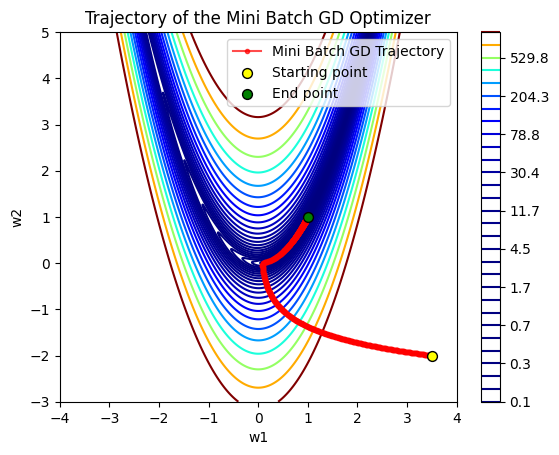

In [ ]:
countour_plot(rosenbrock,trajectory_w1,trajectory_w2,"Mini Batch GD",-4,4,-3,5)

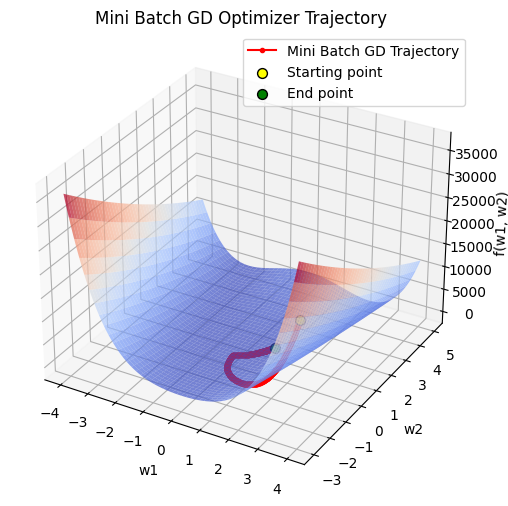

In [ ]:
mesh_plot_with_trajectory(rosenbrock,trajectory_w1,trajectory_w2,"Mini Batch GD",-4,4,-3,5)

### Using SGD with momentum optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MySGDMomentum(rosenbrock,initial_w1=3.5,initial_w2=-2.0,epochs=2000)

Epoch 1, w1: 3.4990100860595703, w2: -1.9998586177825928, Loss: 20312.5
Epoch 2, w1: 3.497129201889038, w2: -1.9995899200439453, Loss: 20292.3515625
Epoch 3, w1: 3.4944465160369873, w2: -1.9992066621780396, Loss: 20254.111328125
Epoch 4, w1: 3.491042137145996, w2: -1.9987200498580933, Loss: 20199.666015625
Epoch 5, w1: 3.4869883060455322, w2: -1.9981403350830078, Loss: 20130.734375
Epoch 6, w1: 3.4823498725891113, w2: -1.9974766969680786, Loss: 20048.89453125
Epoch 7, w1: 3.4771854877471924, w2: -1.9967373609542847, Loss: 19955.5703125
Epoch 8, w1: 3.471547842025757, w2: -1.9959297180175781, Loss: 19852.0625
Epoch 9, w1: 3.465484142303467, w2: -1.9950603246688843, Loss: 19739.54296875
Epoch 10, w1: 3.4590370655059814, w2: -1.9941350221633911, Loss: 19619.07421875
Epoch 11, w1: 3.452244997024536, w2: -1.993159294128418, Loss: 19491.6171875
Epoch 12, w1: 3.4451422691345215, w2: -1.9921377897262573, Loss: 19358.037109375
Epoch 13, w1: 3.437760353088379, w2: -1.991074800491333, Loss: 19219

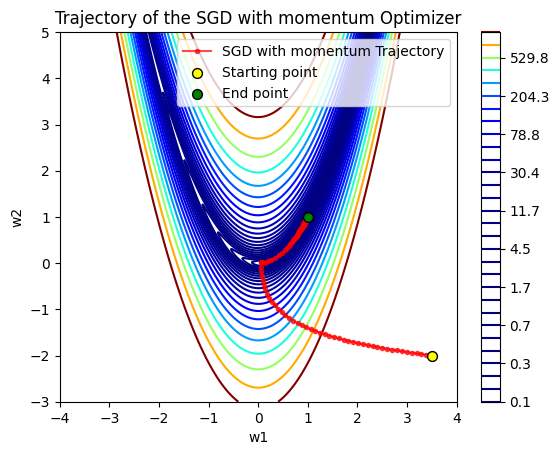

In [ ]:
countour_plot(rosenbrock,trajectory_w1,trajectory_w2,"SGD with momentum",-4,4,-3,5)

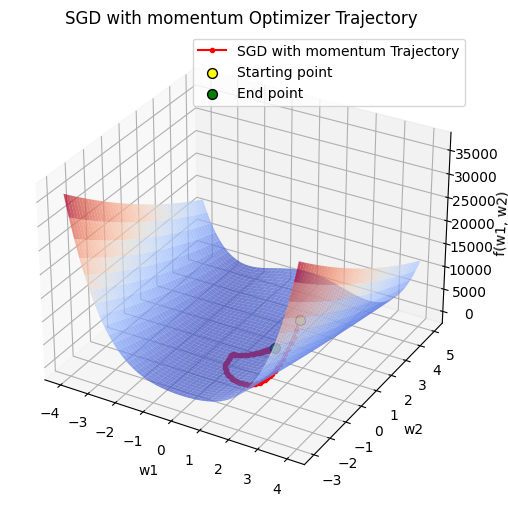

In [ ]:
mesh_plot_with_trajectory(rosenbrock,trajectory_w1,trajectory_w2,"SGD with momentum",-4,4,-3,5)

### Using NAG optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MyNAG(rosenbrock,initial_w1=3.5,initial_w2=-2.0,epochs=5000)

Epoch 1, w1: 3.4990100860595703, w2: -1.9998586177825928, Loss: 20312.5
Epoch 2, w1: 3.497129201889038, w2: -1.9995899200439453, Loss: 20292.3515625
Epoch 3, w1: 3.4944465160369873, w2: -1.9992066621780396, Loss: 20254.111328125
Epoch 4, w1: 3.491042137145996, w2: -1.9987200498580933, Loss: 20199.666015625
Epoch 5, w1: 3.4869883060455322, w2: -1.9981403350830078, Loss: 20130.734375
Epoch 6, w1: 3.4823498725891113, w2: -1.9974766969680786, Loss: 20048.89453125
Epoch 7, w1: 3.4771854877471924, w2: -1.9967373609542847, Loss: 19955.5703125
Epoch 8, w1: 3.471547842025757, w2: -1.9959297180175781, Loss: 19852.0625
Epoch 9, w1: 3.465484142303467, w2: -1.9950603246688843, Loss: 19739.54296875
Epoch 10, w1: 3.4590370655059814, w2: -1.9941350221633911, Loss: 19619.07421875
Epoch 11, w1: 3.452244997024536, w2: -1.993159294128418, Loss: 19491.6171875
Epoch 12, w1: 3.4451422691345215, w2: -1.9921377897262573, Loss: 19358.037109375
Epoch 13, w1: 3.437760353088379, w2: -1.991074800491333, Loss: 19219

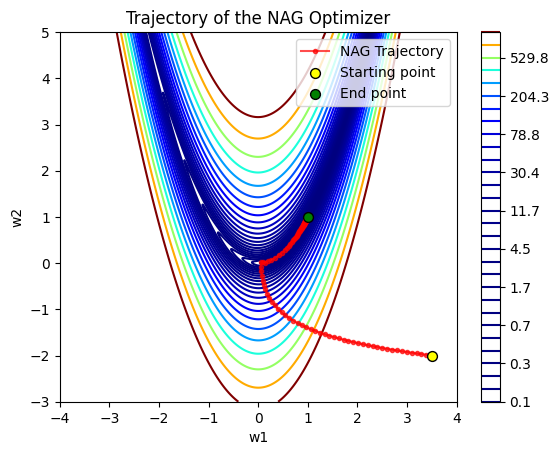

In [ ]:
countour_plot(rosenbrock,trajectory_w1,trajectory_w2,"NAG",-4,4,-3,5)

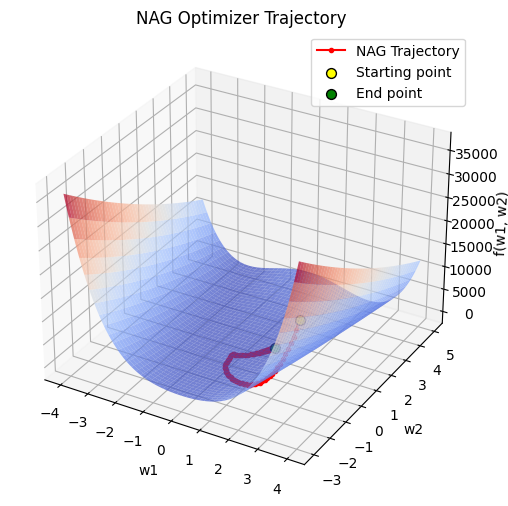

In [ ]:
mesh_plot_with_trajectory(rosenbrock,trajectory_w1,trajectory_w2,"NAG",-4,4,-3,5)

### Using Adam optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MyAdam(rosenbrock,initial_w1=3.5,initial_w2=-2.0,epochs=5000)

Epoch 1, w1: 3.499000072479248, w2: -1.9989999532699585, Loss: 20312.5
Epoch 2, w1: 3.498000144958496, w2: -1.997999906539917, Loss: 20289.705078125
Epoch 3, w1: 3.497000217437744, w2: -1.9969998598098755, Loss: 20266.9296875
Epoch 4, w1: 3.496000289916992, w2: -1.995999813079834, Loss: 20244.169921875
Epoch 5, w1: 3.4950003623962402, w2: -1.9949997663497925, Loss: 20221.43359375
Epoch 6, w1: 3.4940004348754883, w2: -1.993999719619751, Loss: 20198.712890625
Epoch 7, w1: 3.4930005073547363, w2: -1.99299955368042, Loss: 20176.01171875
Epoch 8, w1: 3.4920005798339844, w2: -1.9919993877410889, Loss: 20153.32421875
Epoch 9, w1: 3.4910006523132324, w2: -1.9909992218017578, Loss: 20130.662109375
Epoch 10, w1: 3.4900007247924805, w2: -1.9899989366531372, Loss: 20108.013671875
Epoch 11, w1: 3.4890007972717285, w2: -1.9889986515045166, Loss: 20085.384765625
Epoch 12, w1: 3.4880008697509766, w2: -1.987998366355896, Loss: 20062.7734375
Epoch 13, w1: 3.4870009422302246, w2: -1.9869979619979858, Los

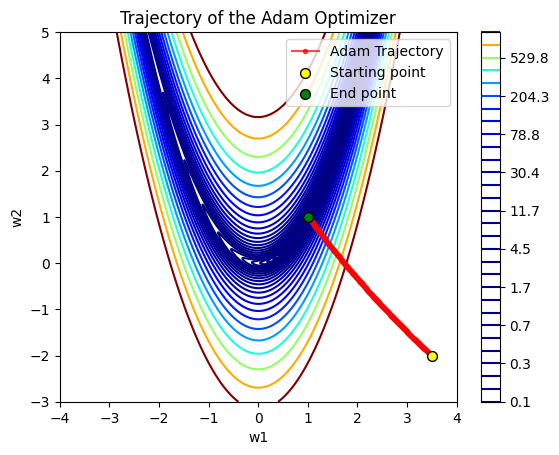

In [ ]:
countour_plot(rosenbrock,trajectory_w1,trajectory_w2,"Adam",-4,4,-3,5)

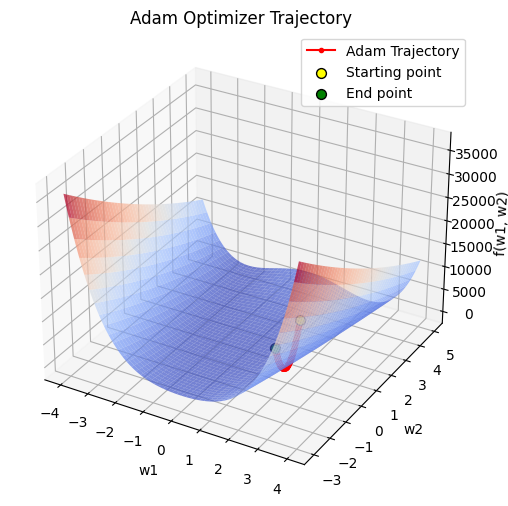

In [ ]:
mesh_plot_with_trajectory(rosenbrock,trajectory_w1,trajectory_w2,"Adam",-4,4,-3,5)

## Beale function

In [ ]:
# Define the Beale function
def beale(w1, w2):
    return (1.5 - w1 + w1*w2)**2 + (2.25 - w1 + w1*(w2**2))**2 + (2.625 - w1 + w1*(w2**3))**2

### Using Mini Batch optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MyMiniBatchGD(beale,initial_w1=-4.0,initial_w2=4.5,epochs=4000)

Epoch 1, w1: -3.9964818954467773, w2: 4.490639686584473, Loss: 132102.8125
Epoch 2, w1: -3.992967128753662, w2: 4.481279373168945, Loss: 130219.0859375
Epoch 3, w1: -3.9894564151763916, w2: 4.471914291381836, Loss: 128358.0234375
Epoch 4, w1: -3.9859492778778076, w2: 4.462549209594727, Loss: 126519.9921875
Epoch 5, w1: -3.9824459552764893, w2: 4.453184127807617, Loss: 124704.90625
Epoch 6, w1: -3.9789466857910156, w2: 4.4438157081604, Loss: 122911.9765625
Epoch 7, w1: -3.9754509925842285, w2: 4.434445858001709, Loss: 121141.125
Epoch 8, w1: -3.971959352493286, w2: 4.425076007843018, Loss: 119392.484375
Epoch 9, w1: -3.9684717655181885, w2: 4.415704250335693, Loss: 117665.609375
Epoch 10, w1: -3.9649875164031982, w2: 4.40632963180542, Loss: 115959.890625
Epoch 11, w1: -3.961507558822632, w2: 4.3969550132751465, Loss: 114275.6875
Epoch 12, w1: -3.958031415939331, w2: 4.387579917907715, Loss: 112612.71875
Epoch 13, w1: -3.954559087753296, w2: 4.378200531005859, Loss: 110970.109375
Epoch 1

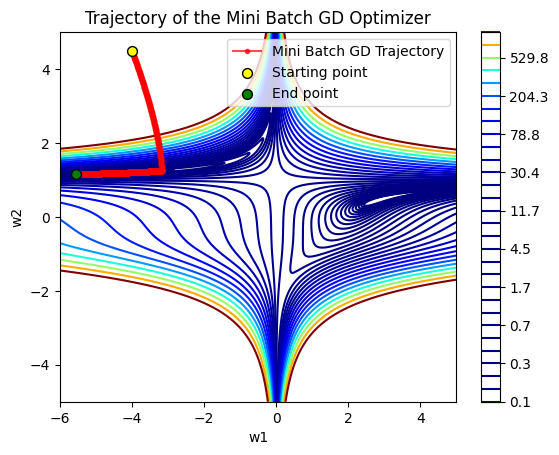

In [ ]:
countour_plot(beale,trajectory_w1,trajectory_w2,"Mini Batch GD",-6)

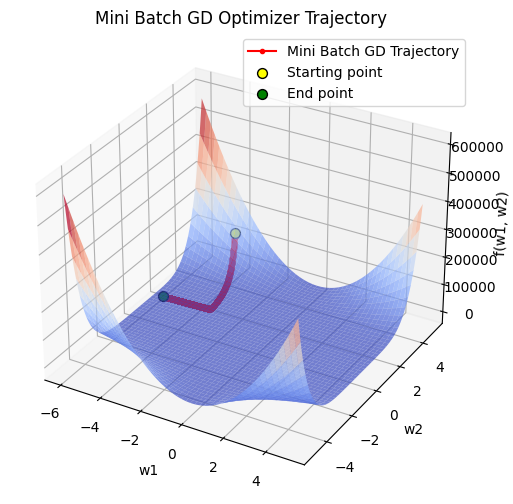

In [ ]:
mesh_plot_with_trajectory(beale,trajectory_w1,trajectory_w2,"Mini Batch GD",-6)

### Using SGD with momentum optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MySGDMomentum(beale,initial_w1=-4.0,initial_w2=4.5,epochs=4000)

Epoch 1, w1: -3.999648094177246, w2: 4.499063968658447, Loss: 133818.328125
Epoch 2, w1: -3.998979330062866, w2: 4.49728536605835, Loss: 133626.796875
Epoch 3, w1: -3.998025417327881, w2: 4.494748592376709, Loss: 133263.421875
Epoch 4, w1: -3.9968152046203613, w2: 4.49152946472168, Loss: 132746.671875
Epoch 5, w1: -3.9953744411468506, w2: 4.487696170806885, Loss: 132093.40625
Epoch 6, w1: -3.9937262535095215, w2: 4.483310222625732, Loss: 131319.109375
Epoch 7, w1: -3.991891384124756, w2: 4.478426456451416, Loss: 130438.0078125
Epoch 8, w1: -3.989888906478882, w2: 4.473094940185547, Loss: 129462.8984375
Epoch 9, w1: -3.9877357482910156, w2: 4.467360019683838, Loss: 128405.6171875
Epoch 10, w1: -3.9854471683502197, w2: 4.461262226104736, Loss: 127276.65625
Epoch 11, w1: -3.983036994934082, w2: 4.454837322235107, Loss: 126085.6796875
Epoch 12, w1: -3.980517625808716, w2: 4.448118209838867, Loss: 124841.2890625
Epoch 13, w1: -3.977900266647339, w2: 4.441134452819824, Loss: 123551.2421875
E

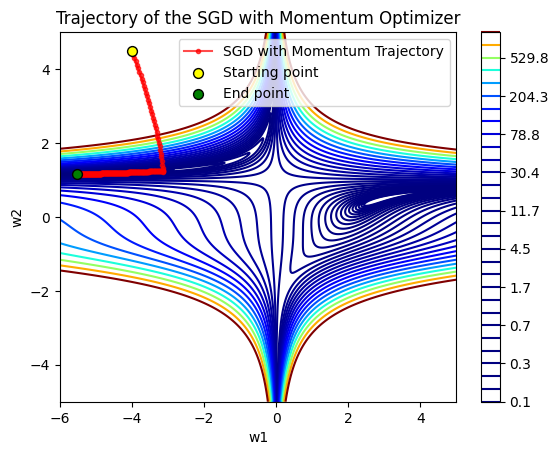

In [ ]:
countour_plot(beale,trajectory_w1,trajectory_w2,"SGD with Momentum",-6)

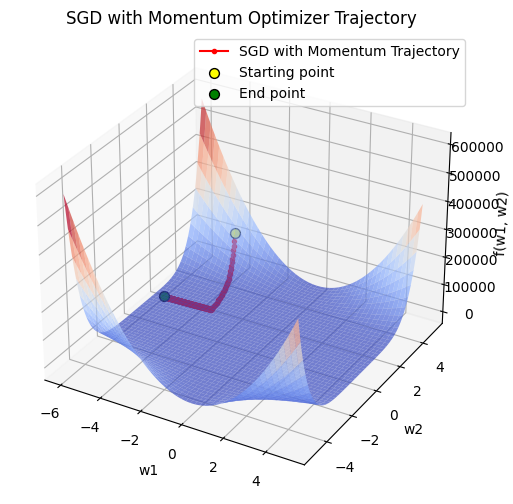

In [ ]:
mesh_plot_with_trajectory(beale,trajectory_w1,trajectory_w2,"SGD with Momentum",-6)

### Using NAG optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MyNAG(beale,initial_w1=-4.0,initial_w2=4.5,epochs=4000)

Epoch 1, w1: -3.999648094177246, w2: 4.499063968658447, Loss: 133818.328125
Epoch 2, w1: -3.998979330062866, w2: 4.49728536605835, Loss: 133626.796875
Epoch 3, w1: -3.998025417327881, w2: 4.494748592376709, Loss: 133263.421875
Epoch 4, w1: -3.9968152046203613, w2: 4.49152946472168, Loss: 132746.671875
Epoch 5, w1: -3.9953744411468506, w2: 4.487696170806885, Loss: 132093.40625
Epoch 6, w1: -3.9937262535095215, w2: 4.483310222625732, Loss: 131319.109375
Epoch 7, w1: -3.991891384124756, w2: 4.478426456451416, Loss: 130438.0078125
Epoch 8, w1: -3.989888906478882, w2: 4.473094940185547, Loss: 129462.8984375
Epoch 9, w1: -3.9877357482910156, w2: 4.467360019683838, Loss: 128405.6171875
Epoch 10, w1: -3.9854471683502197, w2: 4.461262226104736, Loss: 127276.65625
Epoch 11, w1: -3.983036994934082, w2: 4.454837322235107, Loss: 126085.6796875
Epoch 12, w1: -3.980517625808716, w2: 4.448118209838867, Loss: 124841.2890625
Epoch 13, w1: -3.977900266647339, w2: 4.441134452819824, Loss: 123551.2421875
E

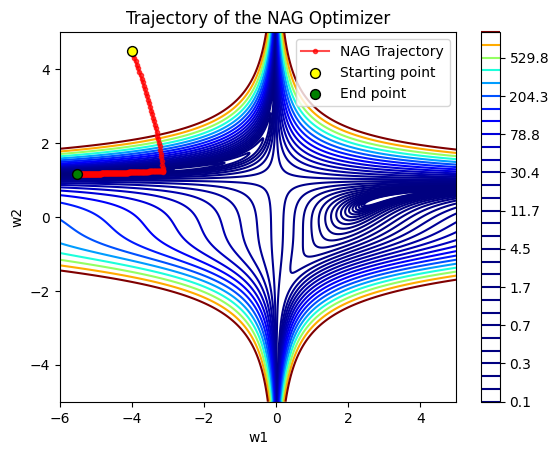

In [ ]:
countour_plot(beale,trajectory_w1,trajectory_w2,"NAG",-6)

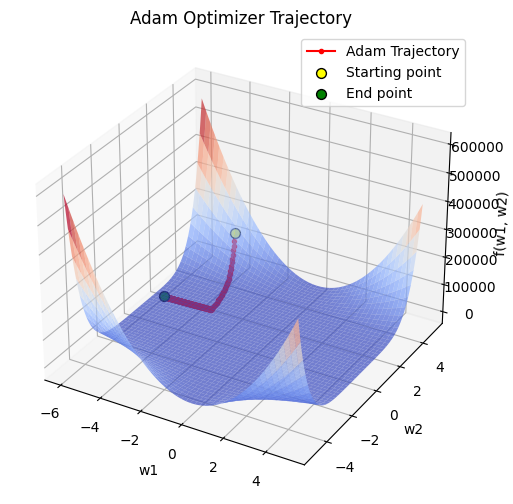

In [ ]:
mesh_plot_with_trajectory(beale,trajectory_w1,trajectory_w2,"Adam",-6)

### Using Adam optimizer

In [ ]:
trajectory_w1,trajectory_w2 = optimize_using_MyAdam(beale,initial_w1=-4.0,initial_w2=4.5,epochs=4000)

Epoch 1, w1: -3.999000072479248, w2: 4.499000072479248, Loss: 133818.328125
Epoch 2, w1: -3.998000144958496, w2: 4.498000144958496, Loss: 133571.640625
Epoch 3, w1: -3.997000217437744, w2: 4.497000217437744, Loss: 133325.390625
Epoch 4, w1: -3.996000289916992, w2: 4.496000289916992, Loss: 133079.53125
Epoch 5, w1: -3.9950003623962402, w2: 4.49500036239624, Loss: 132834.03125
Epoch 6, w1: -3.9940004348754883, w2: 4.494000434875488, Loss: 132588.953125
Epoch 7, w1: -3.9930005073547363, w2: 4.493000507354736, Loss: 132344.265625
Epoch 8, w1: -3.9920005798339844, w2: 4.492000579833984, Loss: 132099.953125
Epoch 9, w1: -3.9910006523132324, w2: 4.491000652313232, Loss: 131856.0625
Epoch 10, w1: -3.9900007247924805, w2: 4.4900007247924805, Loss: 131612.546875
Epoch 11, w1: -3.9890007972717285, w2: 4.4890007972717285, Loss: 131369.421875
Epoch 12, w1: -3.9880008697509766, w2: 4.488000869750977, Loss: 131126.6875
Epoch 13, w1: -3.9870009422302246, w2: 4.487000942230225, Loss: 130884.328125
Epoc

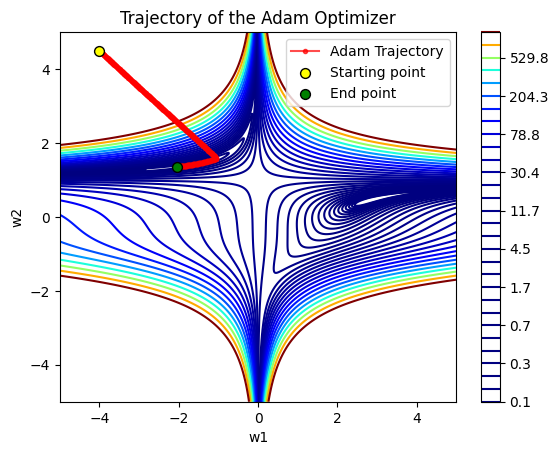

In [ ]:
countour_plot(beale,trajectory_w1,trajectory_w2,"Adam")

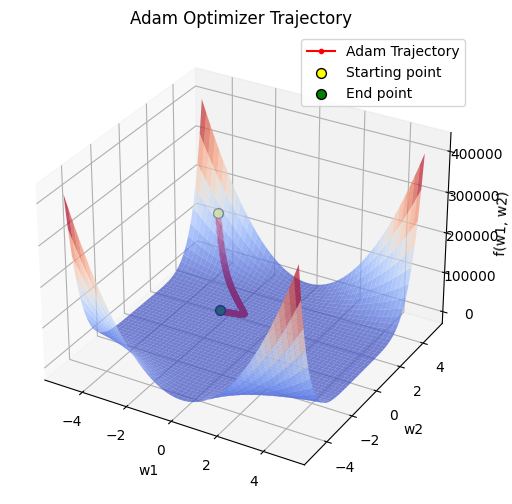

In [ ]:
mesh_plot_with_trajectory(beale,trajectory_w1,trajectory_w2,"Adam")